In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
    train_dir = 'data/kaggle_histo/train/'
test_dir = "data/kaggle_histo/test/"

extracted_features_dir = "extracted_features/"
model_name = "kaggle_vgg19"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/kaggle_histo/train/ 0
data/kaggle_histo/train/cancer 256400
data/kaggle_histo/train/normal 375900
******************************
data/kaggle_histo/test/ 0
data/kaggle_histo/test/cancer 6368
data/kaggle_histo/test/normal 9376


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 474225 images belonging to 2 classes.
Found 158075 images belonging to 2 classes.
Found 15744 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 474225
nb_validation_samples: 158075

predict_size_train: 14820
predict_size_validation: 4940
nb_test_samples: 15744
predict_size_test: 492

 num_classes: 2


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  
model = VGG19(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)

In [11]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 global_average_pooling2d_1


In [12]:
c1 = model.layers[4].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[7].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[12].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[17].output
c4 = GlobalAveragePooling2D()(c4)

con = concatenate([c1, c2, c4])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 474225 samples, validate on 158075 samples
Epoch 1/1000
 - 50s - loss: 0.3589 - acc: 0.8441 - val_loss: 0.3027 - val_acc: 0.8733
Epoch 2/1000
 - 49s - loss: 0.3156 - acc: 0.8676 - val_loss: 0.2911 - val_acc: 0.8801
Epoch 3/1000
 - 49s - loss: 0.3058 - acc: 0.8742 - val_loss: 0.2776 - val_acc: 0.8890
Epoch 4/1000
 - 49s - loss: 0.3019 - acc: 0.8786 - val_loss: 0.2735 - val_acc: 0.8918
Epoch 5/1000
 - 49s - loss: 0.3001 - acc: 0.8814 - val_loss: 0.2731 - val_acc: 0.8941
Epoch 6/1000
 - 49s - loss: 0.2980 - acc: 0.8832 - val_loss: 0.2664 - val_acc: 0.8978
Epoch 7/1000
 - 49s - loss: 0.2975 - acc: 0.8849 - val_loss: 0.2757 - val_acc: 0.8929
Epoch 8/1000
 - 49s - loss: 0.2963 - acc: 0.8862 - val_loss: 0.2691 - val_acc: 0.8989
Epoch 9/1000
 - 49s - loss: 0.2963 - acc: 0.8870 - val_loss: 0.2742 - val_acc: 0.8987
Epoch 10/1000
 - 49s - loss: 0.2963 - acc: 0.8881 - val_loss: 0.2705 - val_acc: 0.8996
Epoch 11/1000
 - 50s - loss: 0.2961 - acc: 0.8884 - val_loss: 0.2764 - val_acc: 0.8961


Epoch 95/1000
 - 48s - loss: 0.2883 - acc: 0.9026 - val_loss: 0.2631 - val_acc: 0.9132
Epoch 96/1000
 - 48s - loss: 0.2878 - acc: 0.9030 - val_loss: 0.2614 - val_acc: 0.9121
Epoch 97/1000
 - 48s - loss: 0.2871 - acc: 0.9029 - val_loss: 0.2641 - val_acc: 0.9101
Epoch 98/1000
 - 48s - loss: 0.2890 - acc: 0.9028 - val_loss: 0.2634 - val_acc: 0.9105
Epoch 99/1000
 - 48s - loss: 0.2877 - acc: 0.9030 - val_loss: 0.2710 - val_acc: 0.9099
Epoch 100/1000
 - 48s - loss: 0.2884 - acc: 0.9030 - val_loss: 0.2790 - val_acc: 0.9103
Epoch 101/1000
 - 48s - loss: 0.2887 - acc: 0.9028 - val_loss: 0.2661 - val_acc: 0.9135
Epoch 102/1000
 - 48s - loss: 0.2882 - acc: 0.9029 - val_loss: 0.2580 - val_acc: 0.9131
Epoch 103/1000
 - 48s - loss: 0.2884 - acc: 0.9029 - val_loss: 0.2619 - val_acc: 0.9129
Epoch 104/1000
 - 48s - loss: 0.2898 - acc: 0.9030 - val_loss: 0.2668 - val_acc: 0.9115
Epoch 105/1000
 - 48s - loss: 0.2877 - acc: 0.9032 - val_loss: 0.2669 - val_acc: 0.9120
Epoch 106/1000
 - 48s - loss: 0.2883 

 - 48s - loss: 0.2904 - acc: 0.9053 - val_loss: 0.2688 - val_acc: 0.9145
Epoch 189/1000
 - 48s - loss: 0.2885 - acc: 0.9054 - val_loss: 0.2652 - val_acc: 0.9142
Epoch 190/1000
 - 48s - loss: 0.2892 - acc: 0.9057 - val_loss: 0.2718 - val_acc: 0.9125
Epoch 191/1000
 - 48s - loss: 0.2876 - acc: 0.9054 - val_loss: 0.2749 - val_acc: 0.9137
Epoch 192/1000
 - 48s - loss: 0.2884 - acc: 0.9055 - val_loss: 0.2669 - val_acc: 0.9141
Epoch 193/1000
 - 48s - loss: 0.2893 - acc: 0.9053 - val_loss: 0.2836 - val_acc: 0.9095
Epoch 194/1000
 - 48s - loss: 0.2891 - acc: 0.9058 - val_loss: 0.2666 - val_acc: 0.9147
Epoch 195/1000
 - 48s - loss: 0.2888 - acc: 0.9056 - val_loss: 0.2705 - val_acc: 0.9133
Epoch 196/1000
 - 48s - loss: 0.2887 - acc: 0.9057 - val_loss: 0.2696 - val_acc: 0.9144
Epoch 197/1000
 - 48s - loss: 0.2876 - acc: 0.9059 - val_loss: 0.2715 - val_acc: 0.9124
Epoch 198/1000
 - 48s - loss: 0.2887 - acc: 0.9055 - val_loss: 0.2647 - val_acc: 0.9143
Epoch 199/1000
 - 48s - loss: 0.2888 - acc: 0.9

Epoch 282/1000
 - 48s - loss: 0.2942 - acc: 0.9066 - val_loss: 0.2769 - val_acc: 0.9135
Epoch 283/1000
 - 48s - loss: 0.2930 - acc: 0.9061 - val_loss: 0.2720 - val_acc: 0.9159
Epoch 284/1000
 - 48s - loss: 0.2921 - acc: 0.9062 - val_loss: 0.2711 - val_acc: 0.9152
Epoch 285/1000
 - 48s - loss: 0.2934 - acc: 0.9068 - val_loss: 0.2861 - val_acc: 0.9124
Epoch 286/1000
 - 48s - loss: 0.2935 - acc: 0.9072 - val_loss: 0.2765 - val_acc: 0.9137
Epoch 287/1000
 - 48s - loss: 0.2929 - acc: 0.9067 - val_loss: 0.2760 - val_acc: 0.9140
Epoch 288/1000
 - 48s - loss: 0.2950 - acc: 0.9066 - val_loss: 0.2722 - val_acc: 0.9157
Epoch 289/1000
 - 48s - loss: 0.2944 - acc: 0.9065 - val_loss: 0.2742 - val_acc: 0.9148
Epoch 290/1000
 - 48s - loss: 0.2928 - acc: 0.9070 - val_loss: 0.2749 - val_acc: 0.9123
Epoch 291/1000
 - 49s - loss: 0.2943 - acc: 0.9069 - val_loss: 0.2790 - val_acc: 0.9135
Epoch 292/1000
 - 48s - loss: 0.2929 - acc: 0.9067 - val_loss: 0.2706 - val_acc: 0.9142
Epoch 293/1000
 - 48s - loss: 0.

 - 48s - loss: 0.2992 - acc: 0.9069 - val_loss: 0.2917 - val_acc: 0.9103
Epoch 376/1000
 - 48s - loss: 0.2988 - acc: 0.9068 - val_loss: 0.2824 - val_acc: 0.9144
Epoch 377/1000
 - 48s - loss: 0.2975 - acc: 0.9068 - val_loss: 0.2872 - val_acc: 0.9141
Epoch 378/1000
 - 48s - loss: 0.2994 - acc: 0.9071 - val_loss: 0.2757 - val_acc: 0.9154
Epoch 379/1000
 - 48s - loss: 0.2998 - acc: 0.9067 - val_loss: 0.2840 - val_acc: 0.9137
Epoch 380/1000
 - 48s - loss: 0.2997 - acc: 0.9069 - val_loss: 0.2845 - val_acc: 0.9144
Epoch 381/1000
 - 48s - loss: 0.3002 - acc: 0.9068 - val_loss: 0.2790 - val_acc: 0.9148
Epoch 382/1000
 - 48s - loss: 0.3001 - acc: 0.9068 - val_loss: 0.2834 - val_acc: 0.9147
Epoch 383/1000
 - 48s - loss: 0.3000 - acc: 0.9068 - val_loss: 0.2818 - val_acc: 0.9137
Epoch 384/1000
 - 48s - loss: 0.2997 - acc: 0.9072 - val_loss: 0.2796 - val_acc: 0.9157
Epoch 385/1000
 - 48s - loss: 0.2995 - acc: 0.9071 - val_loss: 0.2840 - val_acc: 0.9144
Epoch 386/1000
 - 48s - loss: 0.3011 - acc: 0.9

Epoch 469/1000
 - 48s - loss: 0.3069 - acc: 0.9073 - val_loss: 0.2821 - val_acc: 0.9154
Epoch 470/1000
 - 48s - loss: 0.3054 - acc: 0.9077 - val_loss: 0.2833 - val_acc: 0.9155
Epoch 471/1000
 - 48s - loss: 0.3037 - acc: 0.9071 - val_loss: 0.2945 - val_acc: 0.9141
Epoch 472/1000
 - 48s - loss: 0.3047 - acc: 0.9074 - val_loss: 0.2901 - val_acc: 0.9141
Epoch 473/1000
 - 48s - loss: 0.3044 - acc: 0.9077 - val_loss: 0.2918 - val_acc: 0.9160
Epoch 474/1000
 - 48s - loss: 0.3062 - acc: 0.9075 - val_loss: 0.2917 - val_acc: 0.9157
Epoch 475/1000
 - 48s - loss: 0.3084 - acc: 0.9074 - val_loss: 0.2903 - val_acc: 0.9158
Epoch 476/1000
 - 48s - loss: 0.3070 - acc: 0.9072 - val_loss: 0.2921 - val_acc: 0.9164
Epoch 477/1000
 - 48s - loss: 0.3078 - acc: 0.9072 - val_loss: 0.2897 - val_acc: 0.9136
Epoch 478/1000
 - 48s - loss: 0.3065 - acc: 0.9075 - val_loss: 0.2874 - val_acc: 0.9159
Epoch 479/1000
 - 48s - loss: 0.3072 - acc: 0.9074 - val_loss: 0.2849 - val_acc: 0.9156
Epoch 480/1000
 - 48s - loss: 0.

 - 48s - loss: 0.3119 - acc: 0.9072 - val_loss: 0.2945 - val_acc: 0.9144
Epoch 563/1000
 - 48s - loss: 0.3134 - acc: 0.9072 - val_loss: 0.2936 - val_acc: 0.9143
Epoch 564/1000
 - 48s - loss: 0.3104 - acc: 0.9070 - val_loss: 0.2966 - val_acc: 0.9158
Epoch 565/1000
 - 48s - loss: 0.3138 - acc: 0.9073 - val_loss: 0.2952 - val_acc: 0.9149
Epoch 566/1000
 - 49s - loss: 0.3118 - acc: 0.9076 - val_loss: 0.2995 - val_acc: 0.9163
Epoch 567/1000
 - 48s - loss: 0.3135 - acc: 0.9072 - val_loss: 0.3001 - val_acc: 0.9146
Epoch 568/1000
 - 48s - loss: 0.3138 - acc: 0.9069 - val_loss: 0.3018 - val_acc: 0.9137
Epoch 569/1000
 - 48s - loss: 0.3137 - acc: 0.9075 - val_loss: 0.2934 - val_acc: 0.9152
Epoch 570/1000
 - 48s - loss: 0.3131 - acc: 0.9068 - val_loss: 0.3041 - val_acc: 0.9148
Epoch 571/1000
 - 48s - loss: 0.3121 - acc: 0.9070 - val_loss: 0.2936 - val_acc: 0.9135
Epoch 572/1000
 - 48s - loss: 0.3120 - acc: 0.9073 - val_loss: 0.2933 - val_acc: 0.9162
Epoch 573/1000
 - 48s - loss: 0.3129 - acc: 0.9

Epoch 656/1000
 - 48s - loss: 0.3209 - acc: 0.9071 - val_loss: 0.3034 - val_acc: 0.9149
Epoch 657/1000
 - 48s - loss: 0.3193 - acc: 0.9074 - val_loss: 0.3042 - val_acc: 0.9152
Epoch 658/1000
 - 48s - loss: 0.3209 - acc: 0.9071 - val_loss: 0.3053 - val_acc: 0.9145
Epoch 659/1000
 - 48s - loss: 0.3202 - acc: 0.9071 - val_loss: 0.3012 - val_acc: 0.9152
Epoch 660/1000
 - 48s - loss: 0.3204 - acc: 0.9069 - val_loss: 0.2993 - val_acc: 0.9147
Epoch 661/1000
 - 48s - loss: 0.3192 - acc: 0.9068 - val_loss: 0.3013 - val_acc: 0.9144
Epoch 662/1000
 - 48s - loss: 0.3196 - acc: 0.9071 - val_loss: 0.3019 - val_acc: 0.9147
Epoch 663/1000
 - 48s - loss: 0.3199 - acc: 0.9065 - val_loss: 0.2940 - val_acc: 0.9158
Epoch 664/1000
 - 48s - loss: 0.3202 - acc: 0.9073 - val_loss: 0.3051 - val_acc: 0.9157
Epoch 665/1000
 - 48s - loss: 0.3212 - acc: 0.9072 - val_loss: 0.3097 - val_acc: 0.9144
Epoch 666/1000
 - 48s - loss: 0.3222 - acc: 0.9070 - val_loss: 0.2988 - val_acc: 0.9160
Epoch 667/1000
 - 48s - loss: 0.

 - 48s - loss: 0.3256 - acc: 0.9070 - val_loss: 0.3066 - val_acc: 0.9153
Epoch 750/1000
 - 48s - loss: 0.3273 - acc: 0.9071 - val_loss: 0.3084 - val_acc: 0.9150
Epoch 751/1000
 - 48s - loss: 0.3316 - acc: 0.9070 - val_loss: 0.3121 - val_acc: 0.9146
Epoch 752/1000
 - 48s - loss: 0.3278 - acc: 0.9066 - val_loss: 0.3075 - val_acc: 0.9147
Epoch 753/1000
 - 48s - loss: 0.3289 - acc: 0.9069 - val_loss: 0.3086 - val_acc: 0.9146
Epoch 754/1000
 - 48s - loss: 0.3264 - acc: 0.9072 - val_loss: 0.3101 - val_acc: 0.9157
Epoch 755/1000
 - 48s - loss: 0.3254 - acc: 0.9070 - val_loss: 0.3124 - val_acc: 0.9143
Epoch 756/1000
 - 48s - loss: 0.3273 - acc: 0.9070 - val_loss: 0.3150 - val_acc: 0.9154
Epoch 757/1000
 - 48s - loss: 0.3256 - acc: 0.9071 - val_loss: 0.3066 - val_acc: 0.9163
Epoch 758/1000
 - 48s - loss: 0.3277 - acc: 0.9074 - val_loss: 0.3127 - val_acc: 0.9154
Epoch 759/1000
 - 48s - loss: 0.3272 - acc: 0.9073 - val_loss: 0.3104 - val_acc: 0.9149
Epoch 760/1000
 - 48s - loss: 0.3281 - acc: 0.9

Epoch 843/1000
 - 49s - loss: 0.3366 - acc: 0.9069 - val_loss: 0.3246 - val_acc: 0.9134
Epoch 844/1000
 - 48s - loss: 0.3371 - acc: 0.9065 - val_loss: 0.3205 - val_acc: 0.9149
Epoch 845/1000
 - 49s - loss: 0.3357 - acc: 0.9069 - val_loss: 0.3156 - val_acc: 0.9157
Epoch 846/1000
 - 49s - loss: 0.3347 - acc: 0.9067 - val_loss: 0.3190 - val_acc: 0.9147
Epoch 847/1000
 - 48s - loss: 0.3344 - acc: 0.9068 - val_loss: 0.3179 - val_acc: 0.9147
Epoch 848/1000
 - 51s - loss: 0.3369 - acc: 0.9067 - val_loss: 0.3180 - val_acc: 0.9146
Epoch 849/1000
 - 48s - loss: 0.3380 - acc: 0.9070 - val_loss: 0.3196 - val_acc: 0.9154
Epoch 850/1000
 - 48s - loss: 0.3377 - acc: 0.9071 - val_loss: 0.3223 - val_acc: 0.9151
Epoch 851/1000
 - 49s - loss: 0.3367 - acc: 0.9073 - val_loss: 0.3177 - val_acc: 0.9141
Epoch 852/1000
 - 51s - loss: 0.3372 - acc: 0.9069 - val_loss: 0.3176 - val_acc: 0.9148
Epoch 853/1000
 - 50s - loss: 0.3367 - acc: 0.9067 - val_loss: 0.3300 - val_acc: 0.9149
Epoch 854/1000
 - 216s - loss: 0

Epoch 936/1000
 - 48s - loss: 0.3480 - acc: 0.9067 - val_loss: 0.3407 - val_acc: 0.9138
Epoch 937/1000
 - 49s - loss: 0.3527 - acc: 0.9066 - val_loss: 0.3342 - val_acc: 0.9145
Epoch 938/1000
 - 49s - loss: 0.3491 - acc: 0.9067 - val_loss: 0.3358 - val_acc: 0.9151
Epoch 939/1000
 - 49s - loss: 0.3485 - acc: 0.9066 - val_loss: 0.3304 - val_acc: 0.9151
Epoch 940/1000
 - 49s - loss: 0.3525 - acc: 0.9067 - val_loss: 0.3319 - val_acc: 0.9143
Epoch 941/1000
 - 49s - loss: 0.3490 - acc: 0.9063 - val_loss: 0.3299 - val_acc: 0.9146
Epoch 942/1000
 - 49s - loss: 0.3478 - acc: 0.9068 - val_loss: 0.3264 - val_acc: 0.9137
Epoch 943/1000
 - 49s - loss: 0.3499 - acc: 0.9060 - val_loss: 0.3330 - val_acc: 0.9155
Epoch 944/1000
 - 48s - loss: 0.3506 - acc: 0.9070 - val_loss: 0.3341 - val_acc: 0.9145
Epoch 945/1000
 - 49s - loss: 0.3522 - acc: 0.9064 - val_loss: 0.3330 - val_acc: 0.9152
Epoch 946/1000
 - 49s - loss: 0.3489 - acc: 0.9066 - val_loss: 0.3312 - val_acc: 0.9146
Epoch 947/1000
 - 49s - loss: 0.

In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9084095528455285


Confusion Matrix
[[5570  798]
 [ 644 8732]]


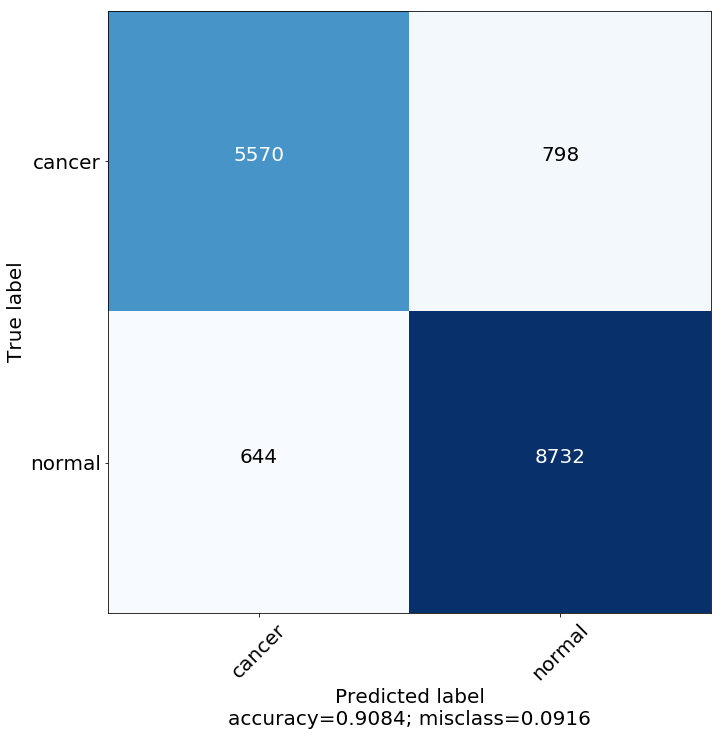

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[5570  798]
 [ 644 8732]]
              precision    recall  f1-score   support

      normal       0.90      0.87      0.89      6368
      cancer       0.92      0.93      0.92      9376

   micro avg       0.91      0.91      0.91     15744
   macro avg       0.91      0.90      0.90     15744
weighted avg       0.91      0.91      0.91     15744



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  89.63630511747667
Specificity :  91.62644281217209


In [22]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.9063137396482438


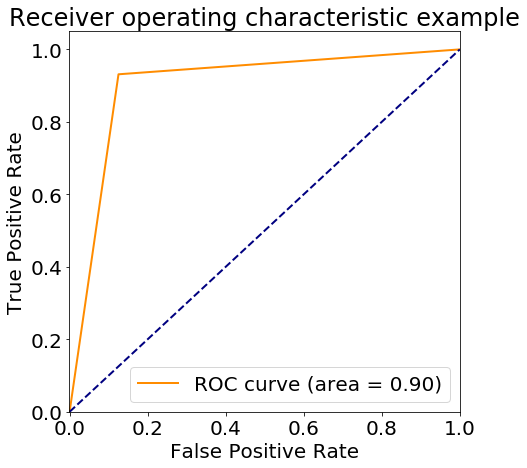

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

15744/15744 [==============================] - 0s 25us/step


In [25]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [26]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

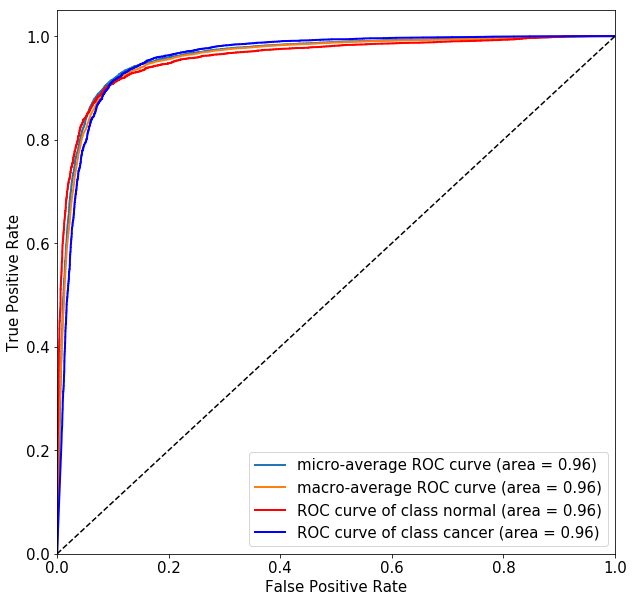

In [27]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [28]:
tn, fp, fn, tp = cm.ravel()

In [29]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.9084095528455285
Precision: 0.9162644281217209
Recall: 0.9313139931740614
tp: 8732
fp: 798
tn: 5570
fn: 644


In [30]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.9237279170633662


In [31]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.9237279170633662


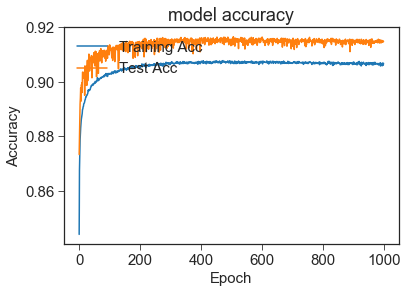

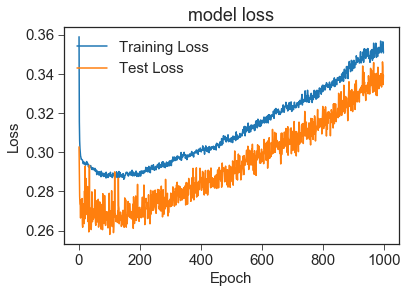

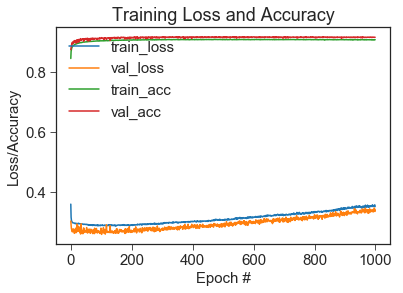

In [32]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")